In [ ]:
# For use with Google Drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/'My Drive'/'Colab Notebooks'/Hierarchical_HAR-PBD

Adjacency matrix:  [[0. 1. 0. 0.]
 [1. 0. 1. 1.]
 [0. 1. 0. 1.]
 [0. 1. 1. 0.]]
Classes in Y validation  [ 1.  2.  3.  4.  5.  6.  7.  9. 11. 14. 17. 18. 20. 21. 22. 23. 24. 25.
 26. 27.]
Classes in Y test  [ 1.  2.  3.  4.  5.  6.  7.  9. 11. 14. 17. 18. 20. 21. 22. 23. 24. 25.
 26. 27.]
[[ 2.]
 [21.]
 [17.]
 [24.]
 [21.]
 [14.]
 [25.]
 [17.]
 [ 3.]
 [ 9.]]
Classes before new encoding  [ 1.  2.  3.  4.  5.  6.  7.  9. 11. 14. 17. 18. 20. 21. 22. 23. 24. 25.
 26. 27.]
Classes after new encoding  [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.]
Classes after new encoding in validation  [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.]
Classes in Y_train:  [ 1.  2.  3.  8. 10. 11. 12. 14. 15.]
Classes in Y validation after subsetting  [ 1.  2.  3.  8. 10. 11. 12. 14. 15.]


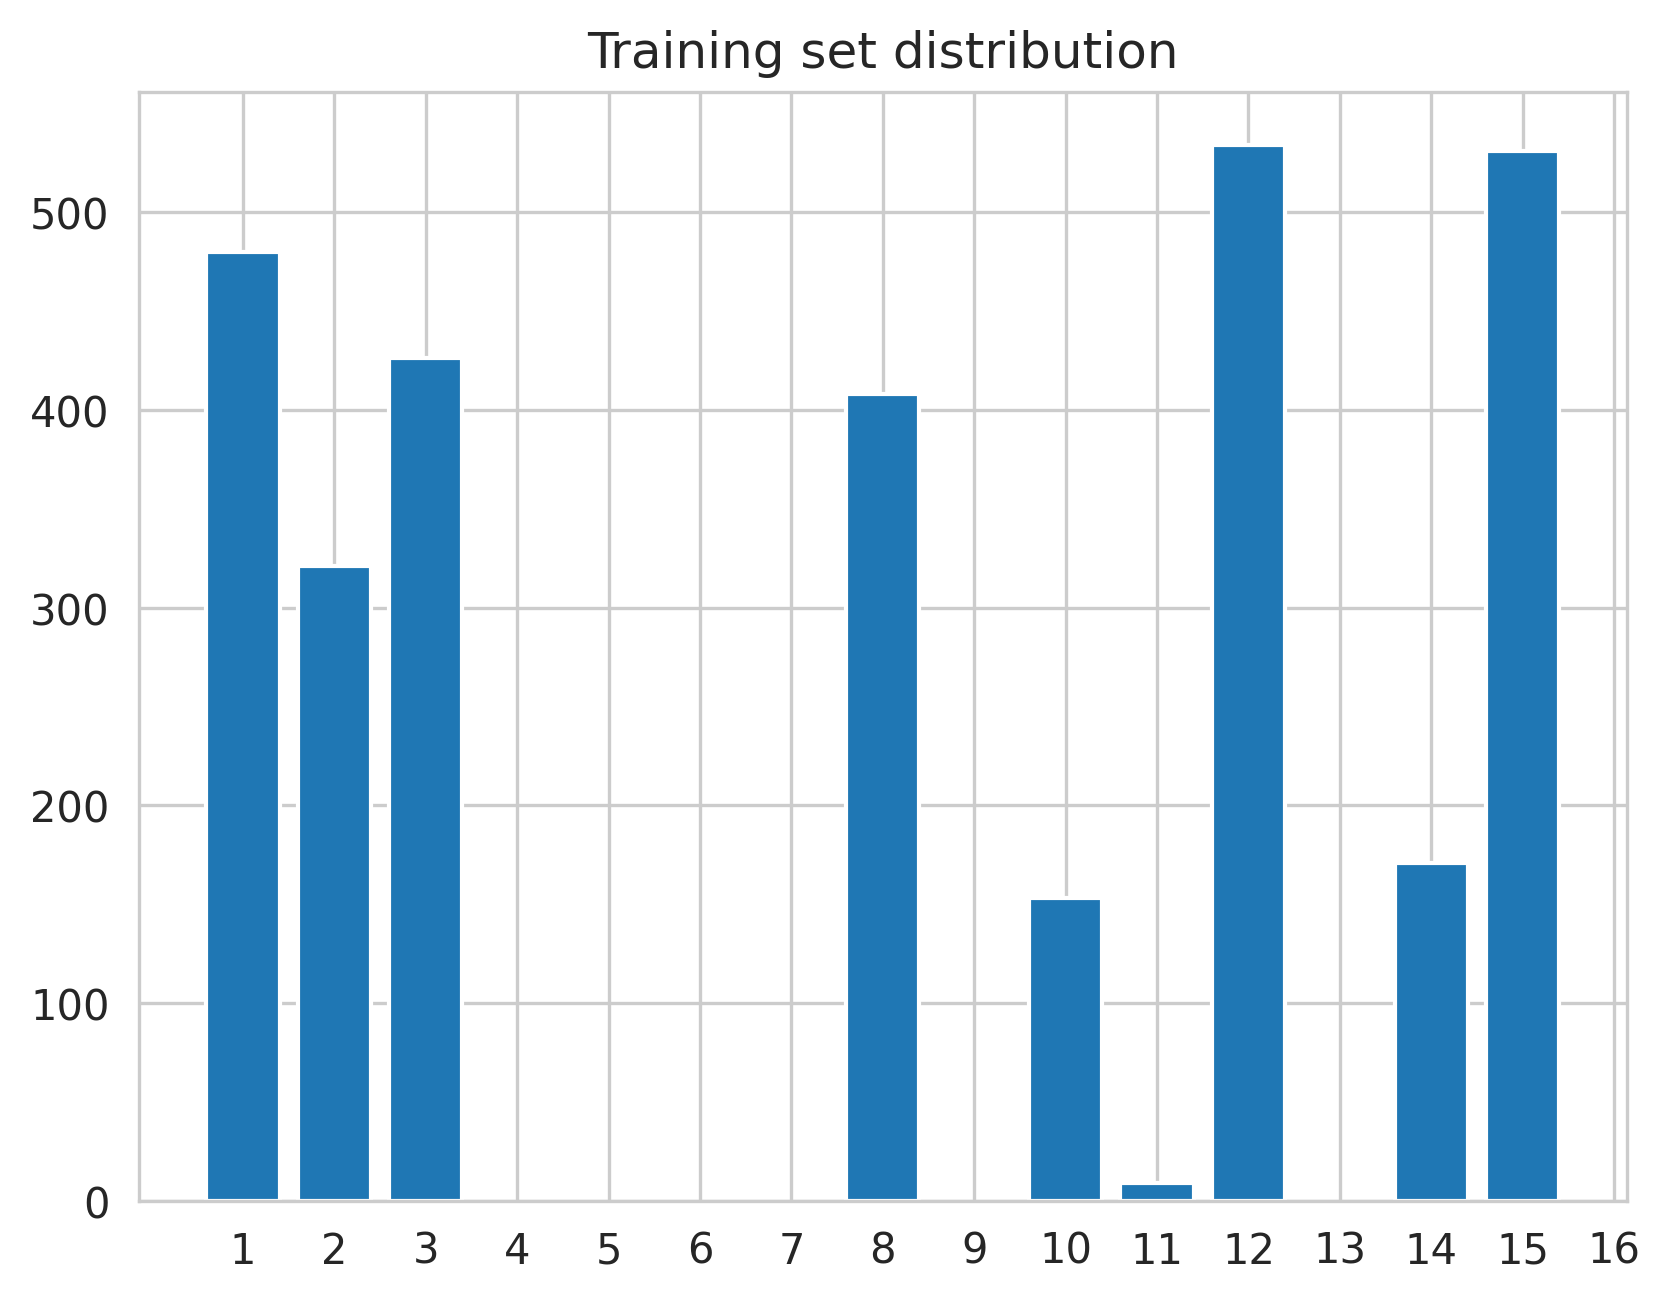

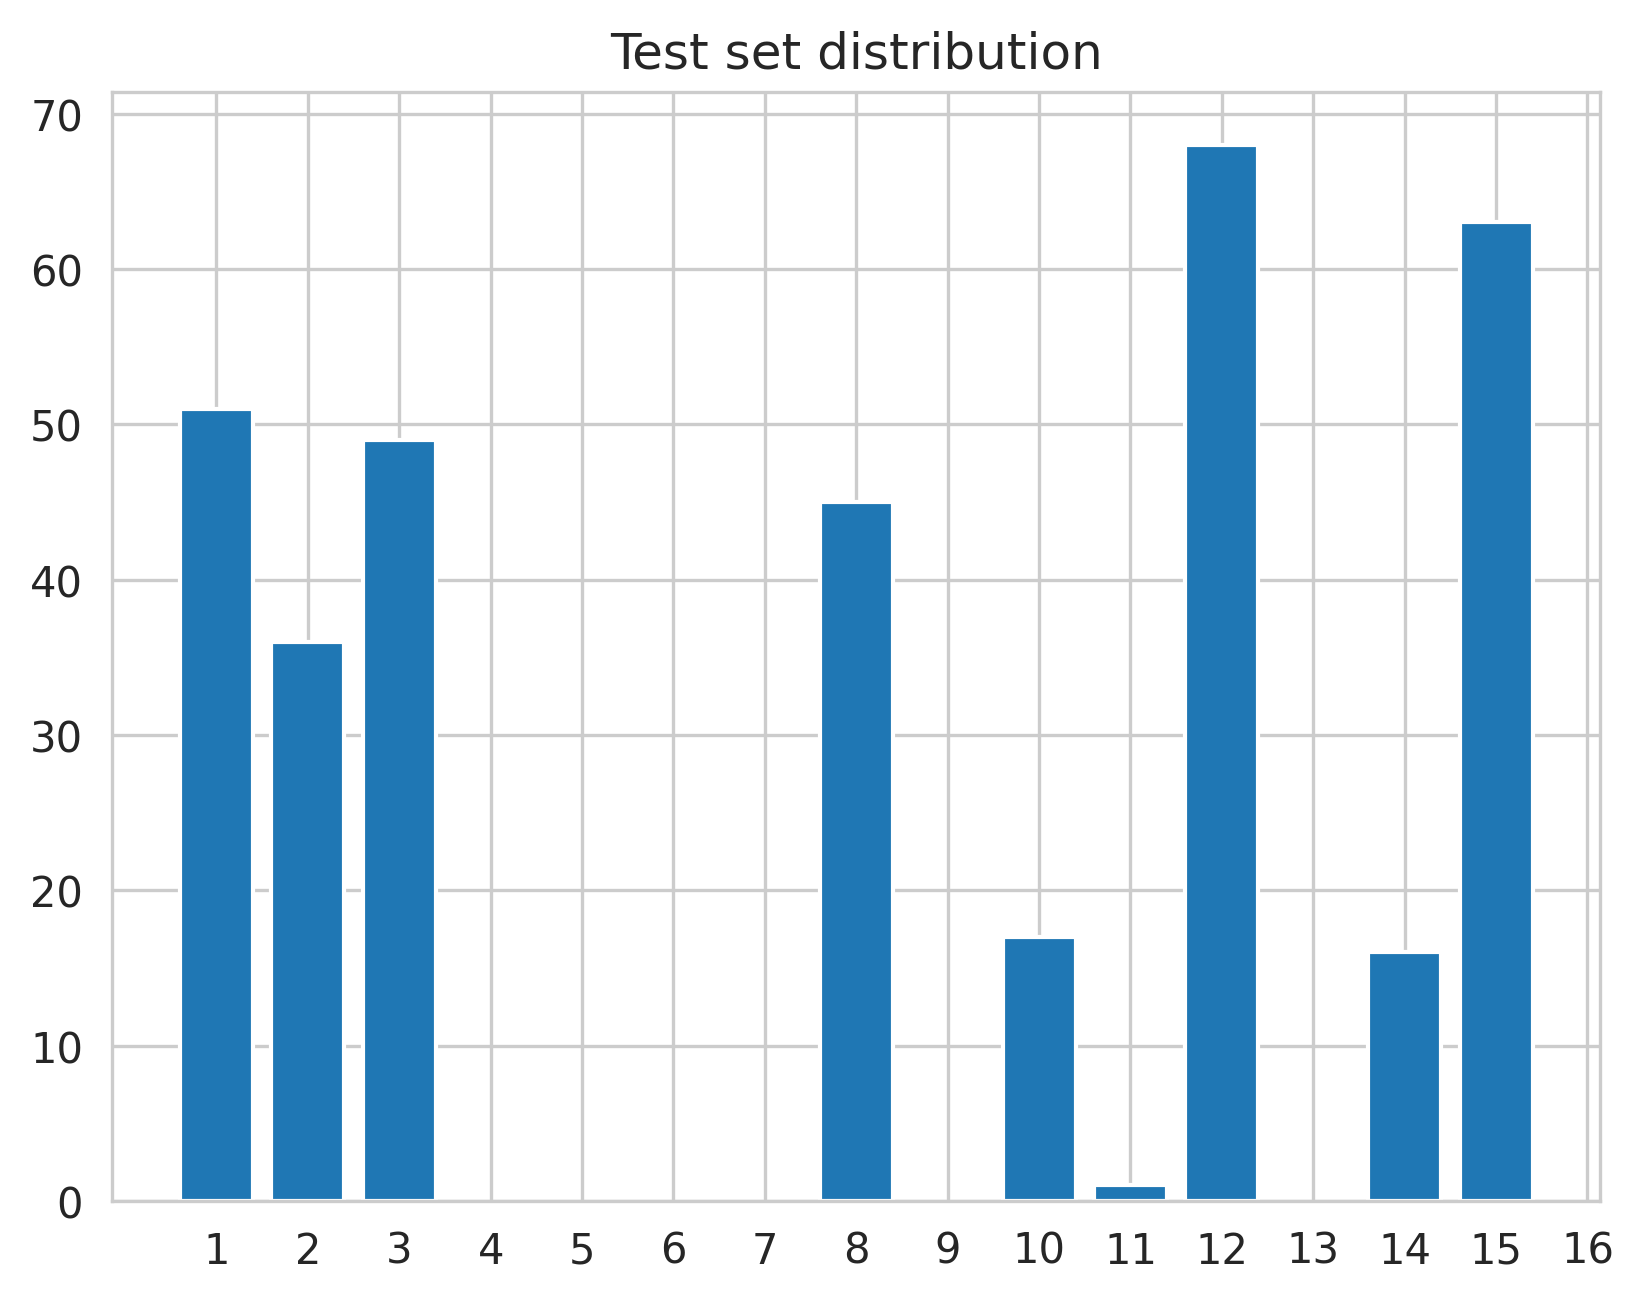

Classes in Y_train:  [1. 2. 3. 4. 5. 6. 7. 8. 9.]
Timestep:  480 Body num:  4 Num classes HAR:  9
HARextend shape:  (None, 480, 4, 9)
HAR temporal output1 shape:  (None, 9)
PDB temporal output1 shape  (None, 2)
Class counts in Y train:  (array([0., 1., 2., 3., 4., 5., 6., 7., 8.]), array([534, 531, 480, 408, 321, 426, 171,   9, 153]))
Class counts in Y test:  (array([0., 1., 2., 3., 4., 5., 6., 7., 8.]), array([68, 63, 51, 45, 36, 49, 16,  1, 17]))
Class counts in Y validation:  (array([0., 1., 2., 3., 4., 5., 6., 7., 8.]), array([52, 56, 56, 48, 36, 47, 22,  1, 17]))
Shape of categorically encoded Y_test:  (346, 9)
Epoch 1/100
21/21 [==============================] - 19s 730ms/step - loss: 0.1300 - categorical_accuracy: 0.1576 - val_loss: 0.1248 - val_categorical_accuracy: 0.1672
Epoch 2/100
21/21 [==============================] - 11s 535ms/step - loss: 0.1246 - categorical_accuracy: 0.1731 - val_loss: 0.1195 - val_categorical_accuracy: 0.1761
Epoch 3/100
21/21 [=====================

KeyboardInterrupt: 

In [1]:
from Baseline.HierarchicalHAR_PBD import build_model
import Baseline.utils as utils
import numpy as np
from collections import Counter
import h5py
import os
import tensorflow as tf
import keras
tf.keras.utils.set_random_seed(42) # Sets it for TF, numpy and base Python
from tensorflow.keras.layers import * # for the new versions of Tensorflow, layers, models, regularizers, and optimizers shall be imported from Tensorflow.
from tensorflow.keras.models import *
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import *
from keras.losses import * # and losses, metrics, callbacks, and backend can still be used from Keras directly.
from keras.metrics import *
from keras import metrics
from sklearn.metrics import *
from keras import backend as K
from keras.backend import *
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from numpy.linalg import inv
from scipy.linalg import fractional_matrix_power
from keras.utils.np_utils import *
from keras.models import load_model
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score,accuracy_score
from sklearn import metrics
import seaborn as sns
import pandas as pd
from helper import max_scale, my_shuffle, max_scale_all, merge_walking
import json
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt

adjacency_matrix = np.zeros((4, 4))
adjacency_matrix[0, 1] = 1
adjacency_matrix[1, 0] = 1
adjacency_matrix[1, 2] = 1
adjacency_matrix[1, 3] = 1
adjacency_matrix[2, 1] = 1
adjacency_matrix[2, 3] = 1
adjacency_matrix[3, 1] = 1
adjacency_matrix[3, 2] = 1
print("Adjacency matrix: ", adjacency_matrix)
norm_adj = utils.MakeGraph(adjacency_matrix)

class HAR_model_wrapper():
    "A class to hold a HAR model and its important properties"
    timestep = 0
    node_num = 0
    feature_num = 0
    adjacency_matrix = None
    num_classes = 0
    def __init__(self, adjacency_matrix, timestep, node_num, feature_num, num_class_HAR=26):
        assert adjacency_matrix.shape[0] == node_num
        assert adjacency_matrix.shape[1] == node_num
        self.model = build_model(timestep=timestep, body_num=node_num, feature_dim=feature_num,
                              gcn_units_HAR=26, lstm_units_HAR=24, adjacency_matrix=adjacency_matrix,
                              gcn_units_PBD=16, lstm_units_PBD=24,
                              num_class_HAR=num_class_HAR, num_class_PBD=2)[1]
        self.num_classes = num_class_HAR
        self.timestep = timestep
        self.node_num = node_num
        self.feature_num = feature_num
        self.adjacency_matrix = adjacency_matrix

X_train = np.load("Data/X_train_pain_12s.npy")
Y_train = np.load("Data/Y_train_pain_12s.npy")
X_test_initial = np.load("Data/X_test_pain_12s.npy")
Y_test_initial = np.load("Data/Y_test_pain_12s.npy")
# The data is ordered by class
# so sampling is non-trivial
my_shuffle(X_test_initial)
my_shuffle(Y_test_initial)
# def stratified_sampling(arr, proportion=0.5, step=10, first=True):
#     if not (step*proportion).is_integer():
#         raise ValueError("Product of step and proportion must be an integer")
#     #@param arr: an array of at least 1 dimension
#     # first: whether the first X%, e.g. with proportion 50%, it will be first 5 of 10
#     new_arr = []
#     stride = int(step*proportion)
#     for i in range(step, arr.shape[0], step):
#         if first:
#             new_arr.append(arr[i-step:i-stride])
#         else:
#             new_arr.append(arr[i-stride:i])
#     return np.array(new_arr, dtype=object)

# Split the test set into validation set
X_validation = X_test_initial[0:int(0.5*X_test_initial.shape[0])]
Y_validation = Y_test_initial[0:int(0.5*Y_test_initial.shape[0])]
print("Classes in Y validation ", np.unique(Y_validation))
X_test = X_test_initial[int(0.5*X_test_initial.shape[0]):]
Y_test = Y_test_initial[int(0.5*Y_test_initial.shape[0]):]
print("Classes in Y test ", np.unique(Y_test))
print(Y_test[0:10])

# Scale the data
max_scale_all(X_train, X_test, X_validation)

# Do not use the merge functions if you use this function
# This function also implements merge option 1
def new_encoding(arr: np.ndarray):
    conversion_dict = {1: 1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7,
                       9:8, 10:11, 11:8, 14:9, 17:10, 18:11, 20:8,
                       21:12, 22:13, 23:14, 24:15, 25:16, 26:17, 27:18}
    for i in range(arr.shape[0]):
        arr[i][0] = conversion_dict[arr[i][0]]
print("Classes before new encoding ", np.unique(Y_train))
new_encoding(Y_train)
new_encoding(Y_test)
new_encoding(Y_validation)
print("Classes after new encoding ", np.unique(Y_train))
print("Classes after new encoding in validation ", np.unique(Y_validation))
# Try to predict only 9 classes
to_predict = [12, 15, 1, 8, 2, 3, 14, 11, 10]
assert len(to_predict) == 9
# Merge walking & walking dogs (18 & 14)
merge_walking(Y_train, Y_test, Y_validation)
# Get indices of X&Y
indices_train = []
indices_test = []
indices_validation = []
for activity_label in to_predict:
    for index in np.where(Y_train[:, 0]==activity_label)[0]:
        indices_train.append(index)
    for index in np.where(Y_test[:, 0]==activity_label)[0]:
        indices_test.append(index)
    for index in np.where(Y_validation[:, 0]==activity_label)[0]:
        indices_validation.append(index)

# Subset
X_train = X_train[indices_train]
X_test = X_test[indices_test]
Y_train = Y_train[indices_train]
Y_test = Y_test[indices_test]
X_validation = X_validation[indices_validation]
Y_validation = Y_validation[indices_validation]
print("Classes in Y_train: ", np.unique(Y_train))
print("Classes in Y validation after subsetting ", np.unique(Y_validation))
assert set(np.unique(Y_train)) == set(to_predict)
# Plot distribution
new_counts = np.unique(Y_train, return_counts=True)
plt.bar(new_counts[0], new_counts[1])
plt.title("Training set distribution")
plt.xticks(ticks=np.arange(1, 17))
plt.show()
new_counts = np.unique(Y_test, return_counts=True)
plt.bar(new_counts[0], new_counts[1])
plt.title("Test set distribution")
plt.xticks(ticks=np.arange(1, 17))
plt.show()
# Because Tensorflow is dumb, it can't to one-shot encoding based
# on the COUNT of labels, but on the literal number
# so more re-encoding needs to be done
for i in range(Y_train.shape[0]):
    Y_train[i][0] = np.where(to_predict==Y_train[i][0])[0][0]+1
for i in range(Y_test.shape[0]):
    Y_test[i][0] = np.where(to_predict==Y_test[i][0])[0][0]+1
for i in range(Y_validation.shape[0]):
    Y_validation[i][0] = np.where(to_predict==Y_validation[i][0])[0][0]+1
print("Classes in Y_train: ", np.unique(Y_train))
# result = np.matmul(norm_adj, X_train[0, 0, :, :])
# print("Result of matrix multiplication of normalized adjacency matrix with "
#       "4x3 matrix from X[0, 0]: ", result,
#       "and its shape: ", result.shape)

#Tensorflow expects classes to start from 0, otherwise it throws a fit
Y_train = Y_train - 1
Y_test = Y_test - 1
Y_validation = Y_validation - 1


class_counts = np.unique(Y_train, return_counts=True)
# Add missing labels to class_counts
def add_missing_labels(class_counts: tuple) -> tuple:
    labels = class_counts[0]
    counts = class_counts[1]
    new_labels = np.array(list(range(0, 26)))
    # Assume that the labels with 0 samples have 1 sample
    # to avoid a divide by zero error
    # the effect of this assumption is quite negligible
    new_counts = np.ones(shape=(26,))
    print(new_counts)
    res = {new_labels[i]: new_counts[i] for i in range(len(new_labels))}
    for i in range(len(labels)):
        res[labels[i]] = counts[i]
    return res


HARmodel = HAR_model_wrapper(adjacency_matrix=adjacency_matrix,
                             timestep=480, node_num=4, feature_num=3, num_class_HAR=9)


def train_model(model: HAR_model_wrapper, X_train: np.ndarray, X_test: np.ndarray,
                Y_train: np.ndarray, Y_test: np.ndarray, X_validation, Y_validation):
    AdjNorm = utils.MakeGraph(model.adjacency_matrix)
    graphtrain = utils.my_combine(AdjNorm, X_train)
    graphtest = utils.my_combine(AdjNorm, X_test)
    graph_validation = utils.my_combine(AdjNorm, X_validation)
    # print("Shape of X train :", X_train.shape)
    # print("Shape of Y train before one-hot encoding: ", Y_train.shape)
    class_counts = np.unique(Y_train, return_counts=True)
    #class_counts = add_missing_labels(class_counts)
    print("Class counts in Y train: ", class_counts)
    print("Class counts in Y test: ", np.unique(Y_test, return_counts=True))
    print("Class counts in Y validation: ", np.unique(Y_validation, return_counts=True))
    # One hot encoding
    Y_train = to_categorical(Y_train, num_classes=model.num_classes)
    Y_test = to_categorical(Y_test, num_classes=model.num_classes)
    # Don't forget validation as well
    Y_validation = to_categorical(Y_validation, num_classes=model.num_classes)
    # print("Shape of categorically encoded Y_train: ", Y_train.shape)
    print("Shape of categorically encoded Y_test: ", Y_test.shape)
    # Beta = 0.9999 produces a really small loss
    model.model.compile(optimizer=Adam(learning_rate=5e-4, decay=1e-5),
                  loss={
                        # 'HARout': 'categorical_crossentropy'
                        'HARout': utils.focal_loss(weights = utils.class_balance_weights(0.30,
                                     class_counts[1]),
                                     gamma=5, num_class=model.num_classes)
                        },
                  loss_weights={'HARout': 1.},
                  metrics=['categorical_accuracy'])

    history = model.model.fit(x=graphtrain,
              y=Y_train,
              batch_size=150,
              epochs=100,
              #callbacks=utils.build_callbacks('Model', str(valid_patient)),
              validation_data=(graph_validation, Y_validation)
              )
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss over training epochs')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    model.model.save("Models/GC_LSTM_HAR")
    return model.model

train = input("Train model? Yes/no")
if train=="Yes":
    model = train_model(HARmodel, X_train, X_test, Y_train, Y_test, X_validation, Y_validation)
else:
    print("Loading model…")
    model = keras.models.load_model("Models/GC_LSTM_HAR")
AdjNorm = utils.MakeGraph(HARmodel.adjacency_matrix)
graphtest = utils.my_combine(AdjNorm, X_test)
print("Y test before categorical encoding: ", Y_test.shape)
predictions = model.predict(graphtest)
print("Shape of predictions: ", predictions.shape)
print("First predictions: ", predictions[0])
# Do these numbers actually sum to 1?
for i in range(predictions.shape[0]):
    print("Sum: ", np.sum(predictions[0]))
    break

#Pretty much. So pick the most likely class
def zeros_and_ones(arr):
    to_return = np.zeros(shape=arr.shape[0])
    for i in range(arr.shape[0]):
        # print("Index of biggest number: ", np.argmax(arr[i]))
        to_return[i] = np.argmax(arr[i])
    return to_return

# Transform predictions back to original shape
predictions = zeros_and_ones(predictions)
# Save results
results = {"F1 score": f1_score(Y_test, predictions, average='weighted'),
           "Accuracy": accuracy_score(Y_test, predictions),
           "Precision": precision_score(Y_test, predictions, average='weighted'),
           "Recall": recall_score(Y_test, predictions, average='weighted'),
           "Confusion matrix": confusion_matrix(Y_test, predictions)}
print("F1 score ", f1_score(Y_test, predictions, average='weighted'))
print("Accuracy ", accuracy_score(Y_test, predictions))
print("Precision ", precision_score(Y_test, predictions, average='weighted'))
print("Recall ", recall_score(Y_test, predictions, average='weighted'))
name = input("Please name this experiment")
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
json.dump(results, open("Results/Experiment_" + name, "w"), cls=NumpyEncoder)